## Run train

In [ ]:
!git clone https://github.com/cvlab-yonsei/MNAD.git
!python MNAD/Train.py --dataset_type anomaly-dataset-mnad --method recon --dataset_path . --gpus 0 --epoch 10 --h 32 --w 32 --batch_size 1 --t_length 1 --num_workers 0

Cloning into 'MNAD'...


## Visualize points after train

In [1]:
import numpy as np
import sys
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sys.path.append('MNAD/')
from model.final_future_prediction_with_memory_spatial_sumonly_weight_ranking_top1 import *

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

labels = []
images = []
img_folder = "anomaly-dataset/test/imgs"
with open('anomaly-dataset/test/test_annotation.txt') as f:
    for line in f:
            filename, label = line.strip().split()
            labels.append(int(label))
            image = Image.open(os.path.join(img_folder, filename))
            image = transform(image)
            images.append(image)

images = torch.stack(images)

In [3]:
model = torch.load('exp/anomaly-dataset-mnad/recon/log/model.pth')
m_items = torch.load('exp/anomaly-dataset-mnad/recon/log/keys.pt')

In [4]:
model.cuda()
model.eval()
m_items_test = m_items.clone()
features_list = []
with torch.no_grad():
    images = Variable(images).cuda()
    outputs, feas, updated_feas, m_items_test, softmax_score_query, softmax_score_memory, compactness_loss = model.forward(images, m_items_test, False)
    features_list.extend(feas.cpu().detach().numpy())

In [5]:
features_list = np.array(features_list)
features_list = features_list.reshape(3794, -1)

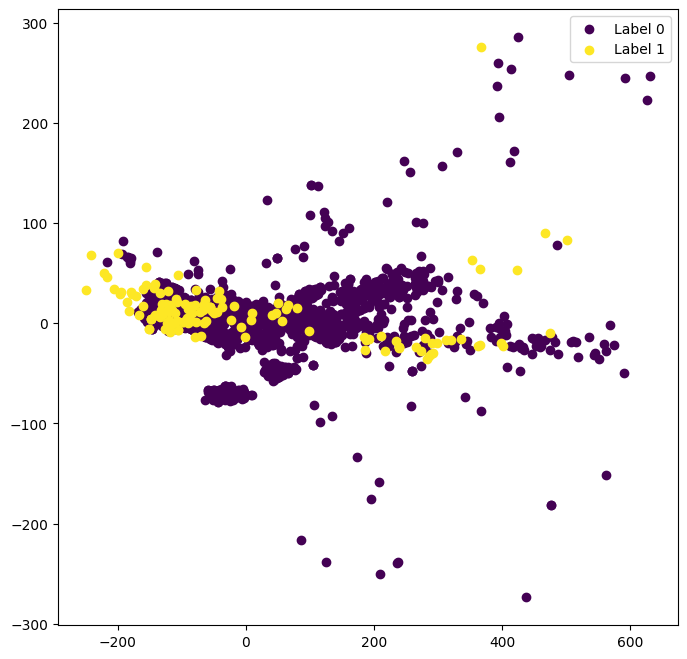

In [7]:
color_map = plt.cm.get_cmap('viridis', 2)
num_labels = len(set(labels))
colors = [color_map(i / num_labels) for i in range(num_labels)]

pca = PCA(n_components=2, svd_solver='full')
embedded = pca.fit_transform(features_list)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
for label, color in zip(set(labels), colors):
    indices = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(embedded[indices, 0], embedded[indices, 1], c=[color], label=f'Label {label}')
ax.legend()
plt.savefig('pca.png')
plt.show()

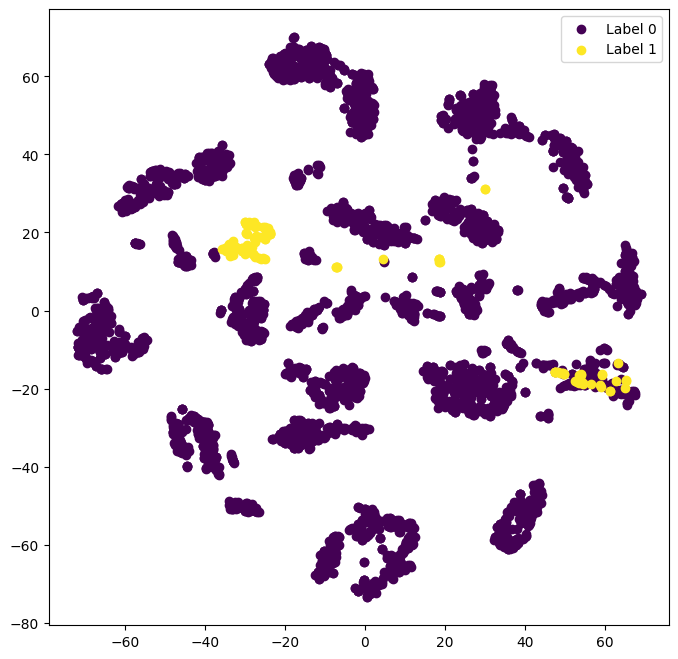

In [8]:
tsne = TSNE(n_components=2, init='pca')
embedded = tsne.fit_transform(features_list)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
for label, color in zip(set(labels), colors):
    indices = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(embedded[indices, 0], embedded[indices, 1], c=[color], label=f'Label {label}')
ax.legend()
plt.savefig('tsne.png')
plt.show()